In [ ]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   
from sklearn.base import clone                    
import matplotlib.pyplot as plt                   
from sklearn.metrics.pairwise import rbf_kernel   

In [ ]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        """
        indicator : Array containing information about how many times eachs of the arms have been played
        q : Array containing expected reward of the arms
        r : Array containing cumulative rewards of the arms
        """
        self.indicator = np.zeros(self.n_arms) 
        self.q = np.inf * np.ones(self.n_arms)
        self.r = np.zeros(self.n_arms)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        self.indicator[arm] += 1
        self.r[arm] += reward
        

In [ ]:
# Define global functions here, if required
# Do exploitation based on highest expected reward
def exploit(avg_rewards):
    return np.random.choice(np.where(avg_rewards == avg_rewards.max())[0]) 

## 1. Implement ε-greedy and UCB MABs

In [ ]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        self.epsilon = epsilon
        self.q = Q0 * np.ones(self.n_arms)
        
    def play(self, context=None):
        super().play(context)
        # Decide whether to explore or not based on bernoulli sample
        explore = np.random.binomial(1, self.epsilon, 1)[0]
        if explore:
            return np.random.randint(0,self.n_arms)
        else:
            return exploit(self.q) 
            
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # update expected rewards
        self.q[arm] = self.r[arm] / self.indicator[arm]

In [ ]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms
        self.rho = rho
        self.q = Q0 * np.ones(self.n_arms)
    
    def play(self, context=None):
        super().play(context)
        return exploit(self.q) 
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # calculate upper bound of expected rewards
        mu_hat = self.r[arm] / self.indicator[arm]
        t = np.sum(self.indicator) + 1
        # add upper bounds to expected rewards
        self.q[arm] = mu_hat + np.sqrt(self.rho * np.log(t)/self.indicator[arm])


## 2. Implement off-policy evaluation

In [ ]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # evaluate MAB until the last event if no n_rounds is set
    n_events = contexts.shape[0]
    if n_rounds==None:
        n_rounds=n_events
        
    out = np.empty(0)
    # iterate over the historical events
    # update MAB state if the chosen arm match with the arm in current event
    for t in range(n_events):
        if len(out) < n_rounds:
            chosen_arm = mab.play(contexts[t])
            if chosen_arm == arms[t]:
                mab.update(chosen_arm, rewards[t], contexts[t])
                out = np.append(out,rewards[t])
        else:
            break
    return out
    

In [ ]:
# load dataset here
N_ARMS = 10
NON_FEAT_COLS = 2
data = np.loadtxt("dataset.txt")
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:].reshape((data.shape[0],N_ARMS,int((data.shape[1]-NON_FEAT_COLS)/N_ARMS)))

In [ ]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.25625


In [ ]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.15875


## 3. Implement LinUCB contextual MAB

In [ ]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        self.alpha = alpha
        # vector containing design matrix of each of the arms
        self.A = np.tile(np.eye(n_dims).ravel(), n_arms).reshape((n_arms,n_dims,n_dims)) 
        # vector containing  product of observed response and features of each of the arms
        self.b = np.zeros(n_dims * n_arms).reshape((n_arms,n_dims,1))
    
    def play(self, context):
        super().play(context)
        # adjust the dimension of the context
        context = np.expand_dims(context, axis=2)
        # calculate parameter of linear regression
        theta = np.linalg.inv(self.A) @ self.b
        # calculate expected rewards based on regression prediction and the upper bound
        p = (theta.transpose((0, 2, 1)) @ context) + (self.alpha * np.sqrt(context.transpose((0, 2, 1)) @ np.linalg.inv(self.A) @ context))
        return exploit(p)
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # adjust the dimension of the context
        context = np.expand_dims(context, axis=2)
        # update design matrix
        self.A[arm] += context[arm] @ context[arm].T
        # update vector of product of response and features
        self.b[arm] += reward * context[arm]

In [ ]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [ ]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        self.n_dims = n_dims
        self.tree = tree
        # set default expected rewards as one for all arms
        self.p = np.ones(n_arms)
        # variables in which historical contexts and reward are stored
        self.y = np.empty(n_arms,dtype=object)
        self.x = np.empty(n_arms,dtype=object)
        
    def play(self, context):
        super().play(context)
        # iterate over the arms
        for i in range(self.p.shape[0]):
            if self.indicator[i] > 0:
                # get current number of rows of context
                ctx_len = self.x[i].shape[0]
                # sample indices from historical contexts with replacement (bootstrap)
                bootstrp_idx = np.random.choice(ctx_len,ctx_len)
                # select associated rows of context and rewards
                bootstrp_x = self.x[i][bootstrp_idx].ravel().reshape(ctx_len,self.n_dims)
                bootstrp_y = self.y[i][bootstrp_idx].ravel()
                # fit decision tree on selected contexts and rewards
                self.tree = self.tree.fit(bootstrp_x,bootstrp_y)
                # predict expected rewards based on observered context
                self.p[i] = self.tree.predict_proba(context[i].ravel().reshape(1,self.n_dims))[0][-1]
        return exploit(self.p)
        
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # update historical contexts and rewards of played arm
        if self.indicator[arm] - 1 == 0:
            self.x[arm] = np.stack((context[arm],context[arm]))
            self.y[arm] = np.stack(([0],[1]))
        self.x[arm] = np.concatenate((self.x[arm],[context[arm]]))
        self.y[arm] = np.concatenate((self.y[arm],[[reward]]))

In [ ]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.60375


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

Text(0, 0.5, 'avg reward')

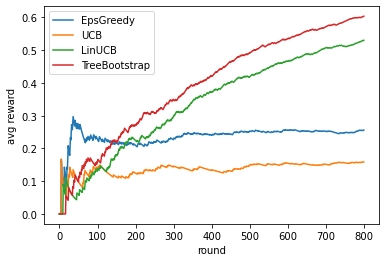

In [ ]:
# calculate per round cumulative average reward
def per_round_reward(mab_result):
    return np.cumsum(mab_result)/np.arange(1, len(mab_result)+1)

EpsGreedy_avg_reward = per_round_reward(results_EpsGreedy)
UCB_avg_reward = per_round_reward(results_UCB)
LinUCB_avg_reward = per_round_reward(results_LinUCB)
TreeBootstrap_avg_reward = per_round_reward(results_TreeBootstrap)

# compare performance of the MABs
plt.plot(EpsGreedy_avg_reward,label='EpsGreedy')
plt.plot(UCB_avg_reward,label='UCB')
plt.plot(LinUCB_avg_reward,label='LinUCB')
plt.plot(TreeBootstrap_avg_reward,label='TreeBootstrap')
plt.legend()
plt.xlabel('round')
plt.ylabel('avg reward')

### 5.B.

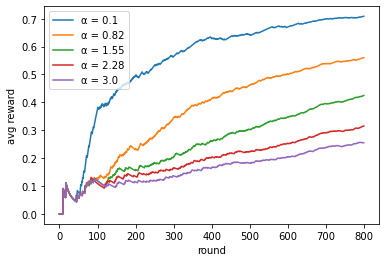

In [ ]:
space_size = 5
n_rounds = 800
# get different values of alphas in given range
alphas = np.linspace(0.1, 3, num=space_size)
avg_reward = np.empty((space_size,n_rounds))
# evaluate LinUCB on different alpha setting
for i,alpha in enumerate(alphas) :
    mab = LinUCB(10, 10, alpha)
    results = offlineEvaluate(mab, arms, rewards, contexts, n_rounds)
    avg_reward[i] = per_round_reward(results)
# compare performance of LinUCB on different alpha setting
for i in range(space_size):
    plt.plot(avg_reward[i],label=f'α = {np.round(alphas[i],2)}')
    if i==4:
        plt.legend()
        plt.xlabel('round')
        plt.ylabel('avg reward')

## 6. Implement KernelUCB contextual MAB

In [ ]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.sigma = np.empty(self.n_arms)
        # vector consisting expected rewards of each arms
        self.u = np.concatenate(([1],np.zeros(self.n_arms-1)))
        # vector to store historical contexts
        self.x = np.empty(0)
        # vector to store historical rewards
        self.y = np.empty(0)
        # variable to store inverse of kernel matrix
        self.k_t_inv = np.empty(0)
        
    def play(self, context):
        super().play(context)
        context = np.expand_dims(context, axis=2)
        if np.sum(self.indicator)>0:
            # calculate kernel between observed context and historical contexts
            k_x_t = np.array([self.kern(i.T,self.x).T for i in context])
            # calculate kernel of obeserved contexts
            k_xt_xt = np.array([self.kern(i.T).ravel()[0] for i in context])
            # calculate upperbound of the reward
            self.sigma = np.sqrt(k_xt_xt-(np.einsum('ijk,lk->ijl', k_x_t.transpose((0,2,1)), self.k_t_inv) @ k_x_t).ravel())
            # calculate expected rewards
            self.u = (k_x_t.transpose((0,2,1)) @ self.k_t_inv @ self.y).ravel() + (self.eta / np.sqrt(self.gamma) * self.sigma)
        return exploit(self.u)
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        context = np.expand_dims(context, axis=2)[arm]
        if np.sum(self.indicator)==1:
            self.x = context.T
            self.y = np.array([reward])
            self.k_t_inv = 1/(self.kern(context.T) + self.gamma)
        else:
            self.x = np.concatenate((self.x,context.T)).reshape((np.sum(self.indicator,dtype=np.int32),self.n_dims))
            self.y = np.concatenate((self.y,[reward]))
            b = self.kern(context.T,self.x[:-1]).T
            k_t_inv_b = self.k_t_inv @ b
            # update block of kernel matrix
            k22 = 1/(self.kern(context.T) + self.gamma - (b.T @ k_t_inv_b))
            k11 = self.k_t_inv + (k22 * k_t_inv_b @ b.T @ self.k_t_inv)
            k12 = -k22 * k_t_inv_b
            k21 = -k22 * b.T @ self.k_t_inv
            # update inverse of kernel matrix
            self.k_t_inv = np.block([
                [k11, k12],
                [k21, k22]
            ])

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.7075


### KernelUCB parameter setting
Since the parameters eta and gamma appears in the same location, we can regard them as a single parameter which is the ratio between the eta and squareroot of gamma. Then we only need to find the optimal value of the ratio, and recover the eta and gamma later from it.

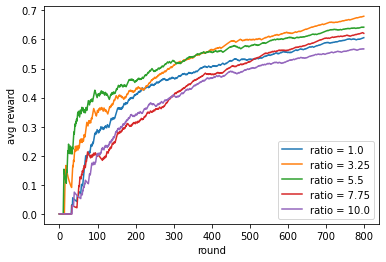

In [ ]:
# initiliase candidate values of parameter
param_ratio = np.linspace(1, 10, num=5)
eta = 1
avg_reward = np.empty((5,800))
for i,ratio in enumerate(param_ratio) :
    mab = KernelUCB(10, 10, np.sqrt(eta)*ratio, eta , rbf_kernel)
    results = offlineEvaluate(mab, arms, rewards, contexts, 800)
    avg_reward[i] = per_round_reward(results)
# compare performance of KernelUCB on different parameter setting
for i in range(space_size):
    plt.plot(avg_reward[i],label=f'ratio = {np.round(param_ratio[i],2)}')
    if i==4:
        plt.legend()
        plt.xlabel('round')
        plt.ylabel('avg reward')

From contour plot above, it can be seen that ratio 3.25 gives us the best performance

### Tuned KernelUCB and LinUCB performance comparison

Text(0, 0.5, 'avg reward')

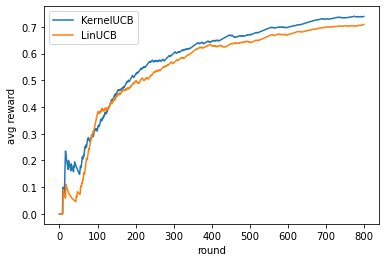

In [ ]:
# initialise KernelUCB with tuned parameters
mab = KernelUCB(10, 10, 3.25, 1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
KernelUCB_avg_reward = per_round_reward(results_KernelUCB)
plt.plot(KernelUCB_avg_reward,label='KernelUCB')
# initialise LinUCB with tuned parameters
mab = LinUCB(10, 10, 0.1)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
LinUCB_avg_reward = per_round_reward(results_LinUCB)
# compare performance between LinUCB and KernelUCB
plt.plot(LinUCB_avg_reward,label='LinUCB')
plt.legend()
plt.xlabel('round')
plt.ylabel('avg reward')